# Figure 1.

Overview of the model set-up for the Trappist-1e case. The *MassFlux* simulation covers the whole sphere, while the *HighRes* simulation is shown by superimposing a high-resolution grid that covers only the substellar region. The graphic shows cloud condensate (white isosurfaces), surface temperature (shading), and free troposphere wind vectors (arrows), focusing on (a) the day side, with the *HighRes* model domain and the cloud condensate isosurface, and (b) the night side of the planet. The cloud condensate is shown using a threshold of $10^{-5}~kg~kg^{-1}$ of total cloud condensate (liquid water plus ice). This figure is available online as an interactive zoom and rotatable figure.

[Skip code and jump to the figure](#Show-the-figure)

----------------------------------

Import the necessary libraries.

In [1]:
import warnings

warnings.filterwarnings("ignore")

Progress bar

In [2]:
from fastprogress import progress_bar

3D visualization and mesh analysis library

In [3]:
import pyvista as pv

Scientific stack

In [4]:
import iris

import numpy as np

In [5]:
from aeolus.core import Run
from aeolus.plot.pv import grid_for_scalar_cube_sph, grid_for_vector_cubes_sph
from aeolus.util import subplot_label_generator

Local modules

In [6]:
from commons import NS_MODEL_TYPES

import mypaths

Set white background for 3d figures.

In [7]:
pv.set_plot_theme("document")

Global definitions.

In [8]:
planet = "trap1e"
run_key = "grcs"
ns_cycle = "20090801T0900Z"

OUTPUT_NAME_PREFIX = f"{planet}_{run_key}"

## Load data

In [9]:
runs = {}
for model_type, model_specs in progress_bar(NS_MODEL_TYPES.items()):
    subdir = f"{planet}_{run_key}"
    label = f"{planet}_{run_key}_{model_type}"
    fpath = (
        mypaths.nsdir
        / subdir
        / ns_cycle
        / model_specs["path"].parent
        / "_processed"
        / f"{subdir}_{model_type}_{ns_cycle}.nc"
    )
    runs[label] = Run(
        files=fpath, name=label, planet=planet, model_type=model_type, processed=True
    )

## Create `pyvista` objects for a composite plot

Set cloud condensate isosurface threshold.

In [10]:
CC_ISOSURF = [1e-5]  # [kg kg-1]
RADIUS = float(runs[label].const.radius.data)  # Planet radius [m]
RADIUS

5804071.0

Set viewpoints.

In [11]:
CAM_POS_LATS = [10, 20]
CAM_POS_LONS = [30, 120]

### Global

Set common visualisation propeties.

In [12]:
z_scale = 100.0
z_offset = RADIUS * 1.01

In [13]:
model_type = "global"

the_run = runs[f"{planet}_{run_key}_{model_type}"]

Create a grid for the surface temperature.

In [14]:
t_sfc = the_run.proc.extract_strict("surface_temperature")

grid_sfc = grid_for_scalar_cube_sph(
    t_sfc, z_offset=z_offset, label=f"{model_type}_sfc_grid"
)

Extract 3 wind components from the global model output.

In [15]:
wind_levels = [5000]  # [m]

winds = the_run.proc.extract(
    iris.Constraint(level_height=lambda x: x in wind_levels)
).extract(["x_wind", "y_wind", "upward_air_velocity"])

Create a grid for the wind vectors.

In [16]:
grid_vec = grid_for_vector_cubes_sph(
    *winds,
    vector_scale=RADIUS * 0.004,
    vertical_wind_scale=1e2,
    z_scale=z_scale,
    z_offset=z_offset,
    xstride=1,
    ystride=1,
    label=f"{model_type}_wind_vectors_grid",
)

In [17]:
grid_vec

StructuredGrid (0x2aab3c017910)
  N Cells:	27313
  N Points:	27648
  X Bounds:	-6.367e+06, 6.367e+06
  Y Bounds:	-6.367e+06, 6.367e+06
  Z Bounds:	-6.368e+06, 6.368e+06
  Dimensions:	144, 192, 1
  N Arrays:	1

Create glyph objects to show wind vectors.

In [18]:
glyphs = grid_vec.glyph(
    orient=f"{model_type}_wind_vectors_grid",
    scale=f"{model_type}_wind_vectors_grid",
    tolerance=0.035,
)

Extract the total cloud condensate.

In [19]:
global_qct = the_run.proc.extract_strict(
    "mass_fraction_of_cloud_liquid_water_in_air"
) + the_run.proc.extract_strict("mass_fraction_of_cloud_ice_in_air")

Create a grid for the cloud condensate and extract a 3D contour (isosurface).

In [20]:
global_qct_cntr = (
    grid_for_scalar_cube_sph(
        global_qct, z_scale=z_scale, z_offset=z_offset, label=f"{model_type}_qct_grid"
    )
    .cell_data_to_point_data()
    .contour(isosurfaces=CC_ISOSURF)
)

### HighRes

Set common visualisation propeties.

In [21]:
z_scale = 120.0
z_offset = RADIUS * 1.02
TOPLEV = 60
DLEV = 2  # use every 2nd level
DY = 3  # stride along y-coordinate
DX = 3  # stride along x-coordinate

In [22]:
model_type = "lam"  # Limited-area model

the_run = runs[f"{planet}_{run_key}_{model_type}"]

Extract the total cloud condensate from the *HighRes* simulation.

In [23]:
lam_qct = the_run.proc.extract_strict(
    "mass_fraction_of_cloud_liquid_water_in_air"
) + the_run.proc.extract_strict("mass_fraction_of_cloud_ice_in_air")

Create a grid from the 3D total cloud condensate field.

In [24]:
lam_grid = grid_for_scalar_cube_sph(
    lam_qct[:TOPLEV:DLEV, ::DY, ::DX],
    z_scale=z_scale,
    z_offset=z_offset,
    label=f"{model_type}_qct_grid",
)

Create an isosurface of the cloud condensate.

In [25]:
lam_qct_cntr = lam_grid.cell_data_to_point_data().contour(isosurfaces=CC_ISOSURF)

Extract a mesh from the HighRes data.

In [26]:
lam_dom = (
    grid_for_scalar_cube_sph(
        lam_qct[:TOPLEV, ::20, ::20],  # show every 20th grid point
        z_scale=z_scale,
        z_offset=z_offset,
        label="lam_dom",
    )
    .extract_geometry()
    .extract_all_edges()
)

## Prepare data for plotting

Pack grids and plotting arguments into a single list.

In [27]:
VIS_CONTAINER = [
    {
        # Global surface temperature
        "mesh": grid_sfc,
        "kwargs": {
            "cmap": "plasma",
            "clim": [160, 285],
            "show_scalar_bar": False,
            "smooth_shading": True,
        },
    },
    {
        # Global wind vectors
        "mesh": glyphs,
        "kwargs": {"cmap": "Greys", "scalars": "GlyphScale", "show_scalar_bar": False},
    },
    {
        # Global cloud condensate
        "mesh": global_qct_cntr,
        "kwargs": {
            "color": "#ededff",
            "clim": [1e-05, 1e-05],
            "opacity": 0.5,
            "show_scalar_bar": False,
            "smooth_shading": True,
        },
    },
    {
        # HighRes cloud condensate
        "mesh": lam_qct_cntr,
        "kwargs": {
            "color": "#ebebff",
            "clim": [1e-05, 1e-05],
            "opacity": 1.0,
            "show_scalar_bar": False,
            "specular": 0.5,
            "ambient": 0.5,
            "smooth_shading": True,
        },
    },
    {
        # HighRes domain edges
        "mesh": lam_dom,
        "kwargs": {
            "style": "wireframe",
            "color": "k",
            "opacity": 0.2,
            "smooth_shading": True,
        },
    },
]

## Plot the results

Assemble the plot.

In [28]:
iletters = subplot_label_generator()

p = pv.Plotter(shape=(1, len(CAM_POS_LONS)), window_size=np.array([1024, 768 // 2]) * 2)

for idx, (cam_lon, cam_lat) in enumerate(zip(CAM_POS_LONS, CAM_POS_LATS)):
    p.subplot(0, idx)

    p.add_text(f"({next(iletters)})", font="times", font_size=24)

    for plot_dict in VIS_CONTAINER:
        p.add_mesh(plot_dict["mesh"], **plot_dict["kwargs"])

    p.set_position(pv.grid_from_sph_coords([cam_lon], [90 - cam_lat], [4.5e7]).points)
    p.set_focus((0, 0, 0))
    p.set_viewup((0, 0, 1))

## Show the figure

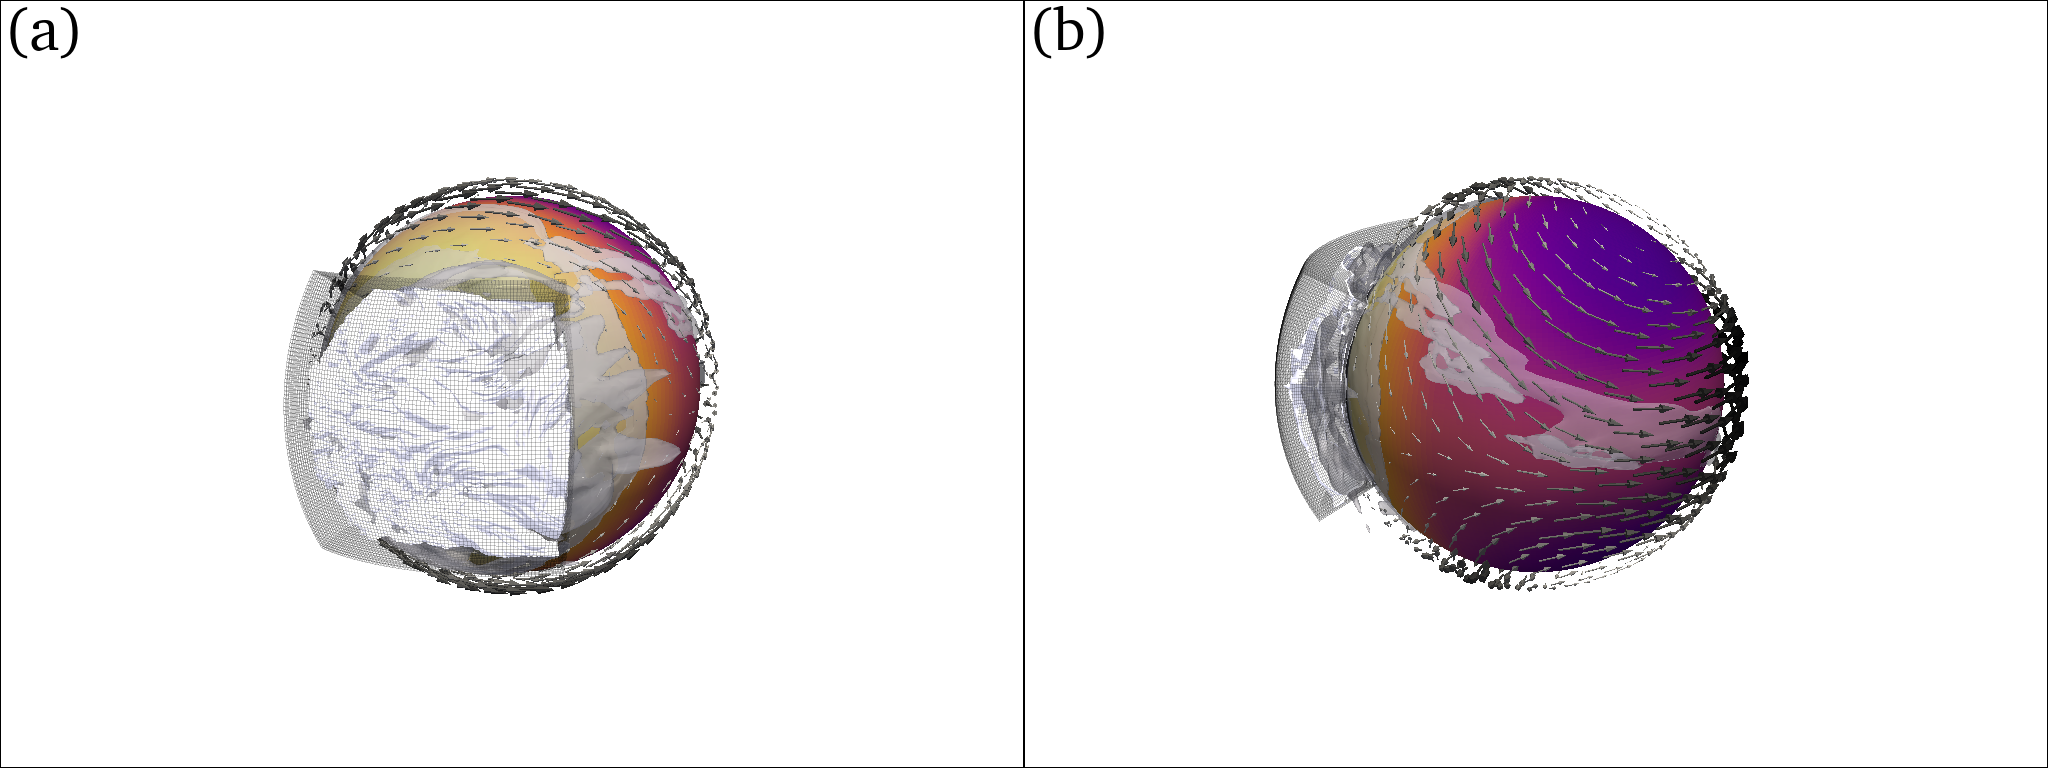

In [29]:
p.show(auto_close=False, use_panel=False)

And save it.

In [30]:
imgname = mypaths.plotdir / f"{OUTPUT_NAME_PREFIX}_110d_view3d"

In [31]:
p.screenshot(f"{imgname}.png", transparent_background=False)
print(f"Saved to ../{imgname.relative_to(mypaths.topdir)}.png")

Saved to ../plots/trap1e_grcs_110d_view3d.png


In [32]:
p.close()

## Appendix A
### Enlarge the static figure

In [33]:
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText

from plot_func import use_style

use_style()

Load the image file.

In [34]:
inp_img = plt.imread(imgname.with_suffix(".png"))

Select the region to zoom into.

In [35]:
img_a = inp_img[140:640, 230:770, :]
img_b = inp_img[140:640, 1230:1780, :]

Plot the two enlarged subplots.

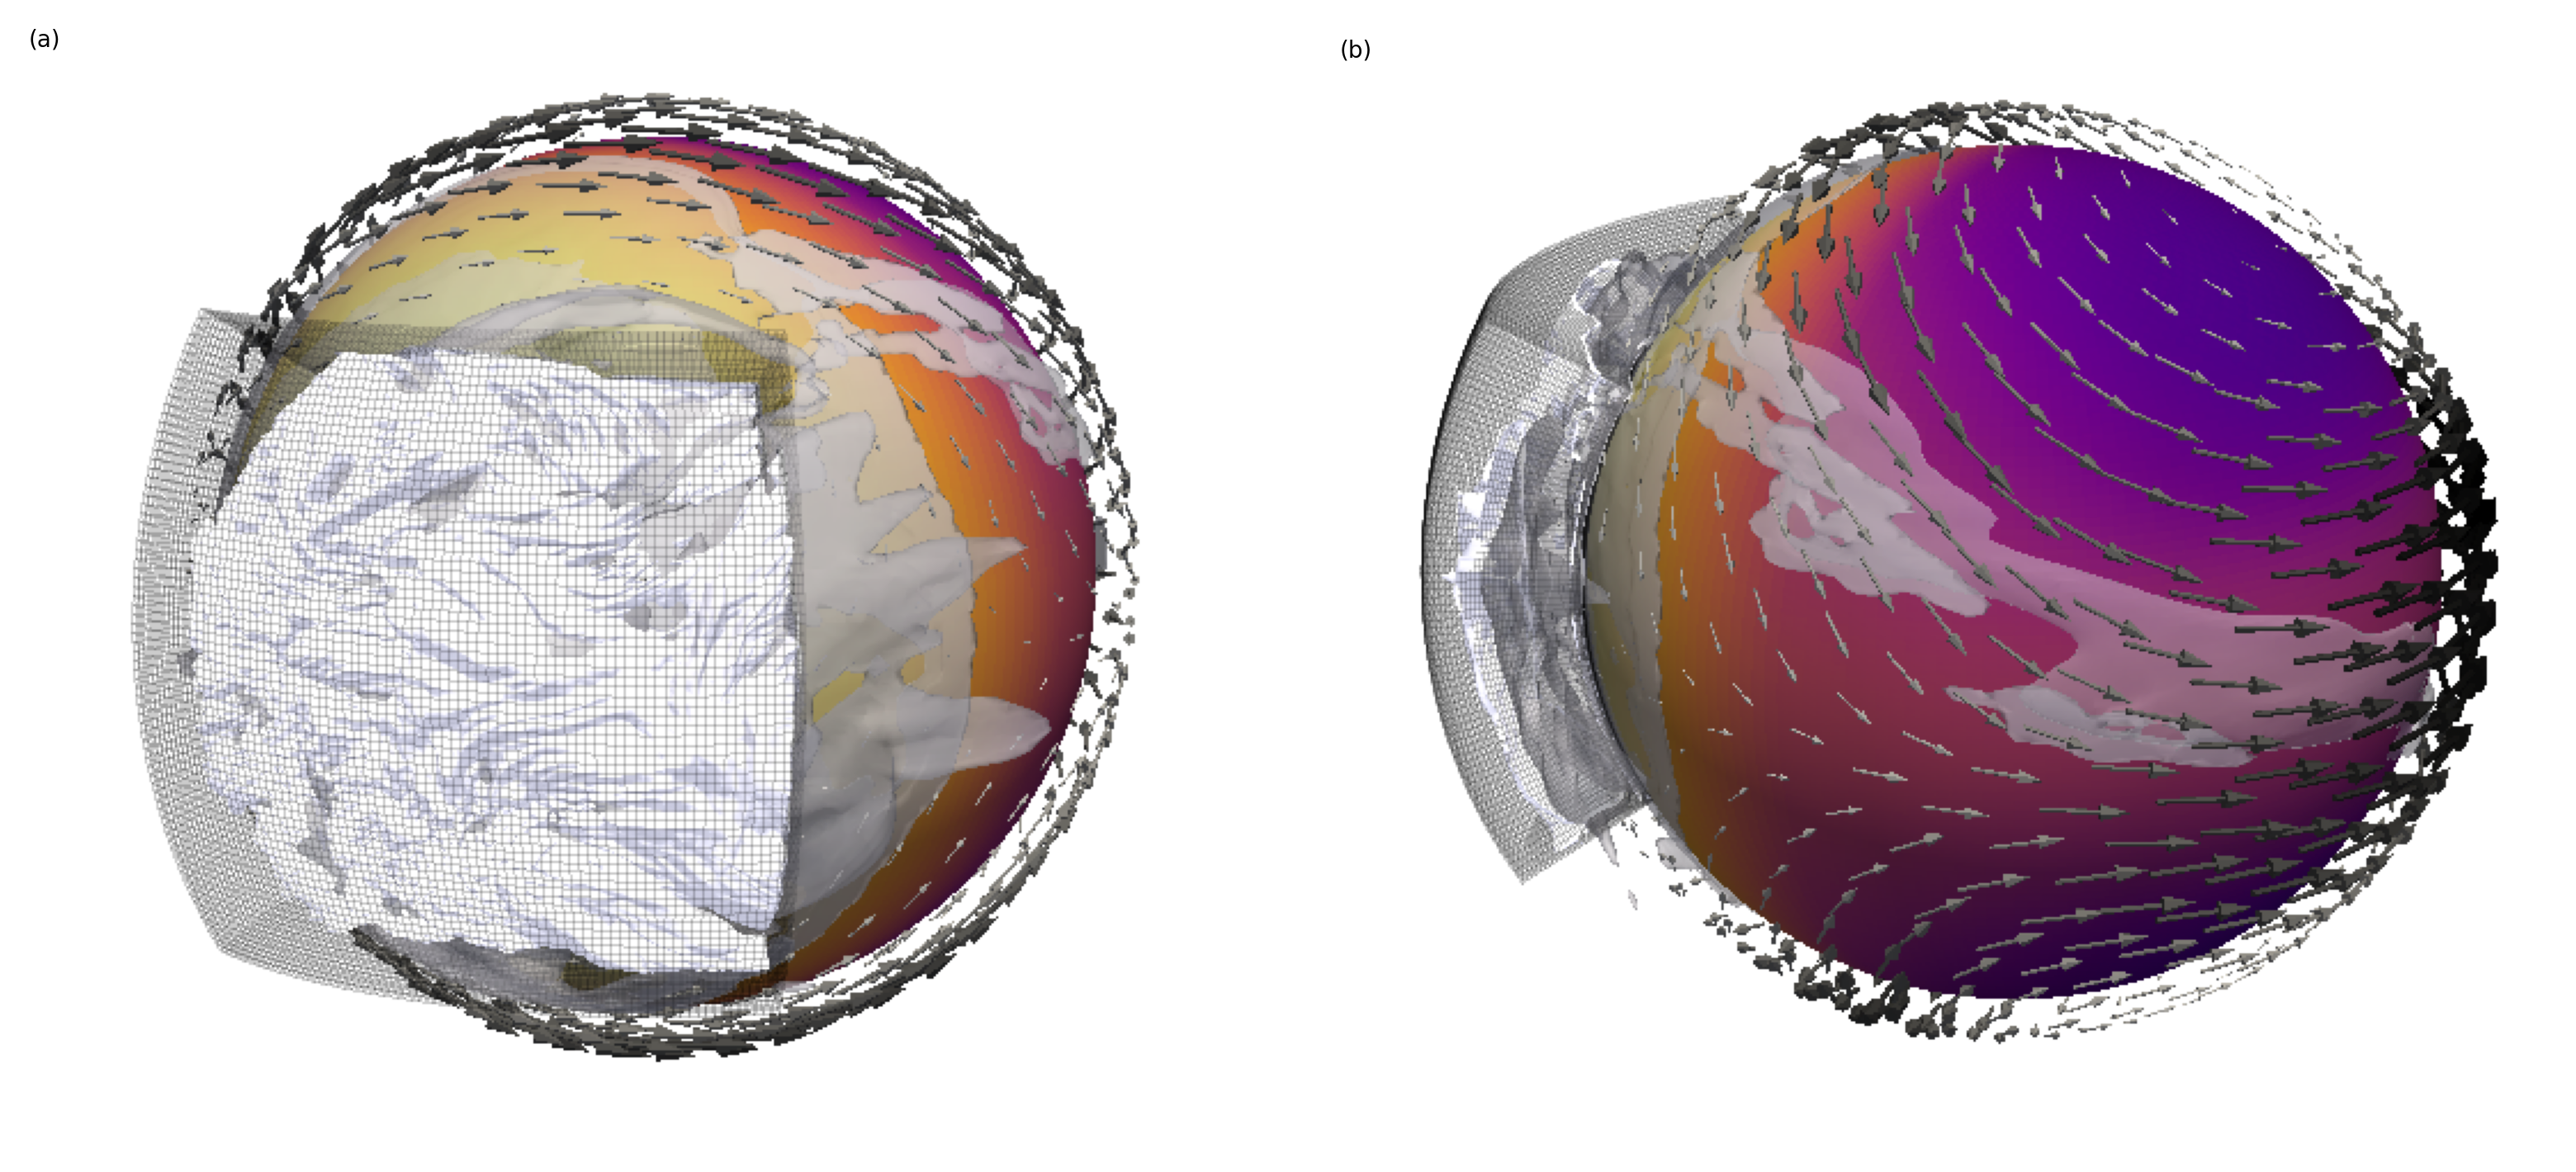

In [36]:
fig, axs = plt.subplots(ncols=2, figsize=(40, 20))

for ax, label, img in zip(axs, ("a", "b"), (img_a, img_b)):
    ax.imshow(img)
    ax.axis("off")

    ax.add_artist(
        AnchoredText(f"({label})", loc=2, frameon=False, prop=dict(size="20"))
    )
plt.subplots_adjust(wspace=0.05)

And save it.

In [37]:
fig.savefig(imgname.with_name(imgname.name + "__enlarged").with_suffix(".png"))

## Appendix B
### Extract to VTKjs

In [38]:
p = pv.Plotter(shape=(1, 1), window_size=np.array([1024, 768 // 2]) * 2)

# Use one viewpoint
cam_lon = CAM_POS_LONS[0]
cam_lat = CAM_POS_LATS[0]

for plot_dict in VIS_CONTAINER:
    p.add_mesh(plot_dict["mesh"], **plot_dict["kwargs"])

p.set_position(pv.grid_from_sph_coords([cam_lon], [90 - cam_lat], [4.5e7]).points)
p.set_focus((0, 0, 0))
p.set_viewup((0, 0, 1))

# p.export_vtkjs(imgname)